## Welcome to Week 4, Single Cell RNA (cont.)!

### This week, we're going to go a bit deeper into scRNA analysis, such as how to interact with Seurat objects, add additional datatypes including CITE-seq and TCR/BCR-seq data, and create custom, publication-ready plots.

We'll continue to use Scanpy, which has some nice capabilities for multi-modal data analysis. The two datatypes we will be working with today at **CITE-seq** and **TCR/BCR-seq** data. The main idea of both is that additional information about the cell is captured using the same cell barcode from reverse transcription so that multiple types of data can be assigned to the same cell. CITE-seq is a method for capturing surface protein information using oligo-conjugated antibodies developed at the New York Genome Center. Here antibodies are conjugated to oligos which contain two important sequences: an antibody specific barcode which is used to quantify surface protein levels in individual cells and a capture sequence (either poly-A sequence or a 10X specific capture sequence) which enables the antibody oligo to be tagged with the cell barcode during reverse transcription. You can look at more details in the publication here:  
* https://www.ncbi.nlm.nih.gov/pubmed/28759029  

Oligo-conjugated anitbodies compatible with 10X scRNA (both 5' and 3') are commercially available from BioLegend (https://www.biolegend.com/en-us/totalseq) and can also be used to multiplex different samples in the same 10X capture. This works by using an antibody which recognizes a common surface antigen and using the antibody barcode to distinguish between samples, a process known as **cell hashing**:
* https://www.ncbi.nlm.nih.gov/pubmed/30567574

We won't be using hashtag data today, but many of the same strategies apply and feel free to reach out if you are interested in learning more!  

The second data type we will be working with is TCR/BCR sequencing data. T and B cells express a highly diverse repertoire of transcripts resulting from V(D)J recombination - the T cell receptor (TCR) in T cells and immunoglobulin (Ig) or BCR in B cells. Daughter cells will share the same TCR/BCR sequence, allowing this sequence to be used to track clonal cell populations over time and space, as well as infer lineage relationships. TCR/BCR sequences are amplified from the cDNA library in the 5' immune profiling 10X kit, allowing these sequences to be matched to the gene expression library from the same cell. For more details, see the 10X website:
* https://www.10xgenomics.com/products/vdj/  

For both of these applications, we'll be following this tutorial:
* https://scanpy-tutorials.readthedocs.io/en/multiomics/cite-seq/pbmc5k.html

### Import Statements

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
from scipy import stats as scistats

import scrublet as scr
import scipy.io

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# you'll need to change these for yourself

path = '/Users/kevin/changlab/covid19/3_scRNA/data/filtered_feature_bc_matrix/'
figpath = '/Users/kevin/changlab/covid19/4_scRNA-part-2/figures/'

# lets set the default figure settings

sc.settings.set_figure_params(dpi_save=300)
sc.settings.figdir = figpath

In [3]:
# helpful plotting functions, "sax" or "simple ax" and "prettify ax" or "pax"

def pax(ax):
    mpl.rcParams['font.sans-serif'] = 'Helvetica'
    for spine in ax.spines.values():
        spine.set_color('k')
    ax.set_frameon=True
    ax.patch.set_facecolor('w')
    ax.tick_params(direction='out', color = 'k', length=5, width=.75, pad=8)
    ax.set_axisbelow(True)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    mpl.rcParams['font.sans-serif'] = 'Helvetica'

def sax(figsize=(6,6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    pax(ax)
    return fig, ax

def sf(fig, fn, formats=['png'], dpi=300, figpath=figpath):
    for f in formats:
        fig.savefig(figpath + fn + '.' + f, dpi=dpi, bbox_inches='tight')

### First, go back to the week three notebook, re-run everything, and save the output so you can just re-import the procssed dataset here.

Or, you can use the file that I outputted to have the same input.  I've included the code that I ran to generate it below.

In [4]:
# # process with scrublet
# print('processing with scrublet')
# counts_matrix = scipy.io.mmread(path + '/matrix.mtx.gz').T.tocsc()
# cells = pd.read_csv(path + '/barcodes.tsv.gz', sep='\t', header=None, names=['barcode'])
# cells = cells.set_index('barcode', drop=False)

# scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.08)
# doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
#                                                           min_cells=3, 
#                                                           min_gene_variability_pctl=85, 
#                                                           n_prin_comps=30)
# predicted_doublets = scrub.call_doublets(threshold=0.25)
# cells['doublet_score'] = doublet_scores
# cells['predicted_doublet'] = predicted_doublets

# # import data
# print('importing data')
# gex = sc.read_10x_mtx(path, gex_only=True)
# gex.obs['doublet_score'] = cells.loc[gex.obs.index, 'doublet_score']
# gex.obs['predicted_doublet'] = cells.loc[gex.obs.index, 'predicted_doublet']

# # preliminary processing
# print('preliminary processing')
# sc.pp.filter_cells(gex, min_genes=200)
# sc.pp.filter_genes(gex, min_cells=3)
# mito_genes = gex.var_names.str.startswith('MT-')
# gex.obs['percent_mito'] = np.sum(
#     gex[:, mito_genes].X, axis=1).A1 / np.sum(gex.X, axis=1).A1
# gex.obs['n_counts'] = gex.X.sum(axis=1).A1
# gex = gex[gex.obs.n_genes >= 500, :]
# gex = gex[gex.obs.percent_mito < 0.1, :]
# sc.pp.normalize_total(gex, target_sum=1e4)
# sc.pp.log1p(gex)
# gex.raw = gex

# # dimensionality reduction
# print('secondary processing')
# sc.pp.highly_variable_genes(gex, n_top_genes=2000)
# gex = gex[:, gex.var.highly_variable]
# sc.pp.regress_out(gex, ['n_genes'])
# sc.pp.scale(gex, max_value=10)
# sc.tl.pca(gex, svd_solver='arpack', n_comps=50)
# sc.pp.neighbors(gex, n_neighbors=10, n_pcs=50, random_state=1)
# sc.tl.leiden(gex, random_state=1, resolution=.4)
# sc.tl.umap(gex)
# new_cluster_names = ['Mono_CD14', #0
#                     'CD4 T', #1
#                     'B', #2
#                     'CD8 T', #3
#                     'NK', #4
#                     'CD8 Tem', #5
#                     'Mono_FCGR3A', #6
#                     'Und1_Doublets', #7
#                     'cDC', #8
#                     'gd T', #9 gamma delta t cells
#                     'pDCs', #10
#                     'Platelets', #11
#                     'Plasma B', #12
#                     'Und2', #13
#                     ]
# gex.rename_categories('leiden', new_cluster_names)

# # plot things
# print('plotting')
# # plot1
# fig = sc.pl.umap(gex, color=['leiden'],
#                 legend_fontsize = 8,
#                 legend_loc = 'on data', return_fig=True)
# fig.savefig(figpath + '0_leiden-clustering-renamed.png', dpi=300, bbox_inches='tight')
# # plot2
# genes_to_plot = ['predicted_doublet','n_genes',
#                 'n_counts','percent_mito']
# fig = sc.pl.umap(gex, color=genes_to_plot, use_raw=True,
#                 sort_order=True, ncols=2, return_fig=True)
# fig.savefig(figpath + '0_umap-metadata.png', dpi=300, bbox_inches='tight')
# # plot3
# genes_to_plot = ['CD3G','CD4','CD8A',
#                  'TRDV2','KLRB1','NKG7',
#                  'CD14','FCGR3A','FCER1A',
#                  'MS4A1','JCHAIN','PPBP',
#                 ]

# fig = sc.pl.umap(gex, color=genes_to_plot, use_raw=True,
#                 sort_order=True, ncols=3,return_fig=True, color_map='Reds')
# fig.savefig(figpath + '0_umap-gene-expression.png', dpi=300, bbox_inches='tight')

# # save the results
# gex.write(figpath + 'scrna_wk3_processed.h5ad', compression='gzip')

In [5]:
# import the data

gex = sc.read_h5ad(figpath + 'scrna_wk3_processed.h5ad')
gex

AnnData object with n_obs × n_vars = 7027 × 1999 
    obs: 'doublet_score', 'predicted_doublet', 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

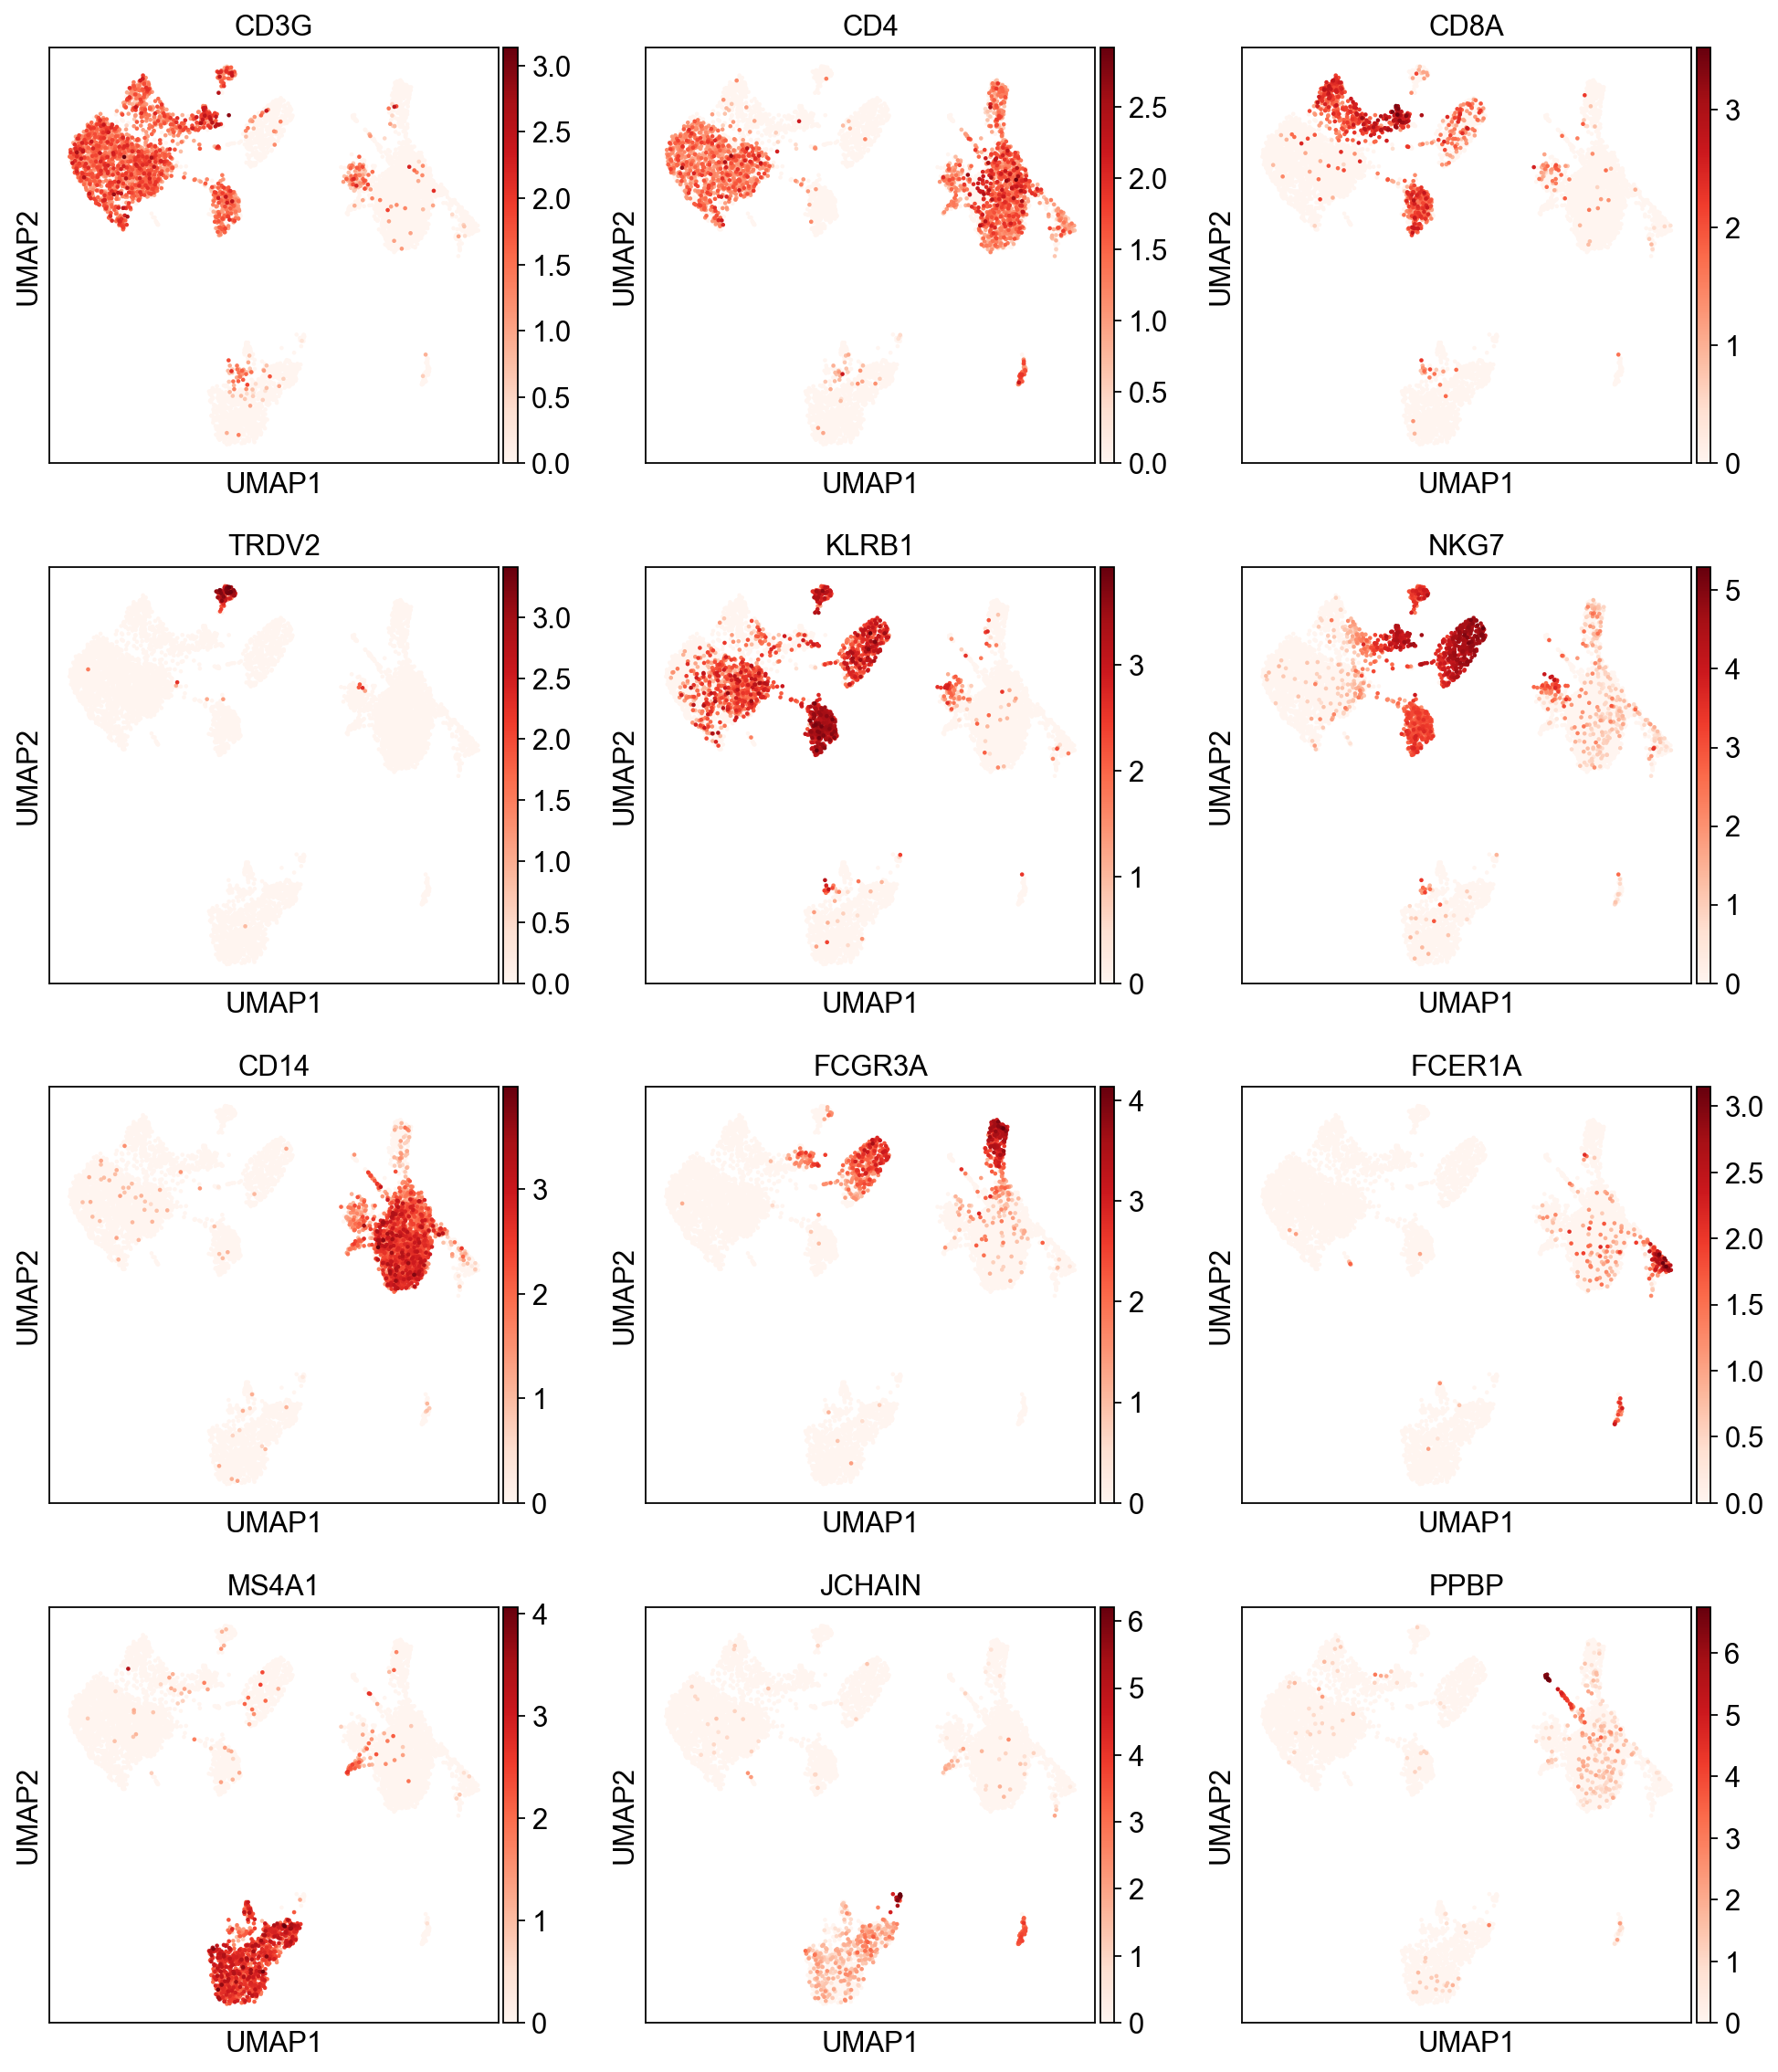

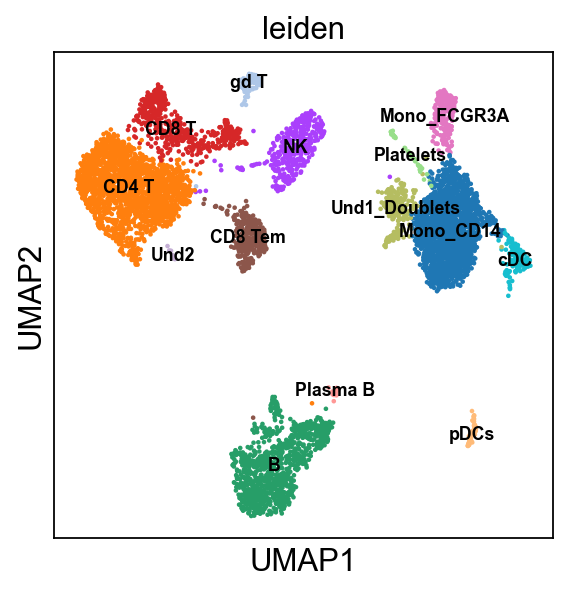

In [6]:
# make sure that everything looks good
genes_to_plot = ['CD3G','CD4','CD8A',
                 'TRDV2','KLRB1','NKG7',
                 'CD14','FCGR3A','FCER1A',
                 'MS4A1','JCHAIN','PPBP',
                ]

fig = sc.pl.umap(gex, color=genes_to_plot, use_raw=True,
                sort_order=True, ncols=3,return_fig=True, color_map='Reds')
plt.show()

fig = sc.pl.umap(gex, color=['leiden'],
                legend_fontsize = 8,
                legend_loc = 'on data', return_fig=True)
plt.show()

### CITE-seq Analysis

In [ ]:
# first, read in the cite seq information
# remember that gex_only=False will let you read them both in

data = sc.read_10x_mtx(path, gex_only=False)
data

In [ ]:
# what cite seq features do we have?
# how many genes?
# how many cite-seq?


In [ ]:
# rename the antibody capture genes
# get rid of the "_TotalSeqC" part of the name just to make our lives easier
# e.g. CD3_TotalSeqC to CD3


In [ ]:
# filter this to just include cells that we analyzed previously, so the datasets will align
# you can do this with

data = data[data.obs.index.isin(gex.obs.index), :]

In [ ]:
# now lets get just the protein information, and make that its own anndata object

protein = data[:, data.var['feature_types'] == 'Antibody Capture'].copy()
protein

### Now let's break out of scanpy for a minute to inspect, normalize, and scale this data on our own

Scanpy seems to be developing some functions specifically for protein data, but hasn't yet implemented them.  But this isn't a problem! We can do things on our own, and transform the data into a format that scanpy wants.

**We're going to break this down in a few steps:**

1. get the raw antibody count data from the protein anndata object.  
2. compute the centered log ratio (CLR) of antibody counts (this is different than for RNA!) - more notes on this below.  
3. scale the data to be mean centered and have unit variance (i.e., z-normalization).  This is the same as for RNA.   
4. save the CLR normalized antibody counts as the raw data of the protein object, and the scaled data as the (normal) data of the protein object, which will be used for dimensionality reduction.  

Now, in terms of what the actual normalizations are: we're going to do this with the .apply() function with dataframes.  I'm providing an example for how to you would do the depth normalization that you'd normally do for RNA-seq below, but you should play around on your own with implementing the normalizations in 2 and 3.

**Normalization methods:**

* depth normalization (as a comparison).  For a cell, divide the counts for each gene/antibody by the sum of all gene/antibody counts for that cell, then multiply by some scaling factor (e.g. 10,000).  Commonly, you would also log transform this, and add a pseudocount (say 1).  This is sometimes referred to as **log1p**.
* CLR.  For an antibody, divide the counts for each antibody by the geometric mean antibody counts across all cells, then take the natural log of this.  Similarly, you'll add a pseudocount of 1.
* z-normalization (scaling to zero mean and unit variance).  Basically, you're making all datapoints have similar distributions.  For a gene, return the count for a cell minus the mean count across all cells, divided by the standard deviation across all cells.
* clipping extremes.  You can use the np.clip() function to do this.  Basically, this will take any value lower than the lower bound in np.clip and make it equal to the lower bound, and do the same for the upper bound.  You might combine this with computing the mean and standard deviation, to clip values > 3 stds away from the mean; or np.percentile() to clip values that are less or greater than a given percentile in the data.

It's worth taking the time to look at why the CLR transformation is better than a simple log transformation.  Why?  Because antibodies aren't genes - when a gene is negative, the count is 0; when a gene is positive, the count is greater than 0.  But does this hold true with antibodies?  When an antibody is negative, the count isn't necessarily 0 - the antibody might have background!  The CLR transformation does a better job of dealing with this, by looking at the relative abundance of the antibody.

In [ ]:
# get the raw data

protein_orig = pd.DataFrame(protein.X.todense(), index=protein.obs.index, columns=protein.var.index).T

In [ ]:
# what does your data look like?

# I'd recommend first plotting the distribution of total antibody counts across all cells


# sf(fig, '1_preprocess_histogram_antibody-counts')

In [ ]:
# what if we just take a 'naive' approach to normalization?

protein_norm_depth = protein_orig.apply(lambda x: 10000 * x / x.sum(), axis=0)
protein_norm_depth = np.log(protein_norm_depth + 1)

# plot the distribution of counts for all of these

fig = plt.figure(figsize=(10,10))
axes = [fig.add_subplot(5,4,i+1) for i in range(len(protein_norm_depth.index))]
xlim = [protein_norm_depth.min().min(), protein_norm_depth.max().max()]

bins = np.linspace(xlim[0], xlim[1], 100)

for ix, p in enumerate(protein_orig.index):
    ax = axes[ix]
    pax(ax)
     
    vals = protein_norm_depth.loc[p]

    ax.hist(vals, bins=bins)
    ax.set_title(p, size=16)
    ax.set_xlim(xlim)

fig.tight_layout()
plt.show()

sf(fig, '1_preprocess_log1p-distributions')

In [ ]:
# now lets compare this with the CLR approach
def clr(x, pseudo=1):
    x = x + pseudo
    geo_mean = scistats.gmean(x)
    return np.log(x / geo_mean)

protein_norm_clr = protein_orig.apply(clr, axis=1)
protein_norm_clr.head()

# plot the distribution of counts for all of these



# sf(fig, '1_preprocess_clr-distributions')

In [ ]:
# now lets compare the two with a scatter plot


# sf(fig, '1_preprocess_scatter-norm-methods')

In [ ]:
# now scale this to unit variance
# see https://en.wikipedia.org/wiki/Feature_scaling under z-normalization


# also, clip extremes - clip anything less than -10 and above 10


In [ ]:
# plot the distribution of counts for all of the scaled data
# note how the distributions are relatively similar


# sf(fig, '1_preprocess_scaled_clr-distributions')

In [ ]:
# what if we want to make a scatter plot of one CD4 vs CD8a?
# compare the depth-normalized vs CLR normalized counts
# make it once with depth-normalized counts and once with CLR normalized


# sf(fig, '1_preprocess_scatter_log1p_cd4-8')

In [ ]:
# what if we want to make a scatter plot of one antibody?


# sf(fig, '1_preprocess_scatter_clr_cd4-8')

### Now go back to scanpy

Let's save the protein_norm_clr values as the raw data in protein, and the protein_scaled values in the data slot of protein.  Let's also exclude the control proteins from the main data slot.

In [ ]:
protein = data[:, data.var['feature_types'] == 'Antibody Capture'].copy()

protein.var['control'] = ['control' in i for i in protein.var.index]
protein.X = protein_norm_clr.T
protein.raw = protein

protein.X = protein_scaled.T
protein = protein[:, ~protein.var['control']]

protein

In [ ]:
protein.var

In [ ]:
protein_genes = ['CD3D','CD19','PTPRC',
                'CD4','CD8A','CD14','FCGR3A',
                'NCAM1','IL2RA','PTPRC',
                'PDCD1','TIGIT','IL7R','FUT4']
protein.var['rna_name'] = protein_genes
name_dict = dict(zip(protein.var.index, protein.var['rna_name']))
protein.var.head()

In [ ]:
sc.pp.pca(protein, n_comps=len(protein.var)-1)
sc.pp.neighbors(protein, n_neighbors=30, n_pcs=len(protein.var)-1)
sc.tl.leiden(protein, key_added="protein_leiden", resolution=.33)

In [ ]:
sc.tl.umap(protein)

In [ ]:
genes_to_plot = protein.var.index.tolist() + ['protein_leiden']

fig = sc.pl.umap(protein, color=genes_to_plot,
                sort_order=True, ncols=4,return_fig=True, color_map='Blues', use_raw=True,
                vmin='p5', vmax='p99.9')
fig.set_size_inches(12,12)
sf(fig,'2_umap_with_cite-clustering')
plt.show()

### Now let's integrate this with the RNA data

I'm going to do this a little fast and loose because I think that scanpy hasn't yet fully implemented the CITE-seq stuff too well.  Basically, we're going to add the umap coordinates and clustering information from the RNA processed data to the protein-processed data, and vice versa.

In [ ]:
# add gex to protein
protein.obsm['RNA_umap'] = gex[protein.obs.index].obsm['X_umap']
protein.obs['rna_leiden'] = gex.obs.loc[protein.obs.index, 'leiden']

# add protein to gex
gex.obsm['CITE_umap'] = protein[gex.obs.index].obsm['X_umap']
gex.obs['protein_leiden'] = protein.obs.loc[gex.obs.index, 'protein_leiden']

In [ ]:
# now, let's plot the cite-seq information on top of the rna clusters

genes_to_plot = protein.var.index.tolist() + ['rna_leiden']

fig = sc.pl.embedding(protein, 'RNA_umap', color=genes_to_plot,
                sort_order=True, ncols=4,return_fig=True, color_map='Blues', use_raw=True,
                vmin='p5', vmax='p99.9', legend_fontsize=8)
fig.set_size_inches(12,12)
sf(fig,'3_RNA-umap_with_CITE-counts')
plt.show()

In [ ]:
# and, let's plot some rna-seq information on top of the cite clusters
# I'll leave you to do this one

# sf(fig,'3_CITE-umap_with_RNA-counts')

### Now, let's plot RNA information against CITE information to see how they compare.

In [ ]:
# first, get the metadata from the scanpy .obs dataframe

meta = gex.obs
meta.head()

In [ ]:
# and add in the umap coordinates from the RNA
meta['umap_1'] = gex.obsm['X_umap'][:, 0]
meta['umap_2'] = gex.obsm['X_umap'][:, 1]

# now add in the umap coordinates from the CITE-seq
meta['umap-cite_1'] = protein[meta.index].obsm['X_umap'][:, 0]
meta['umap-cite_2'] = protein[meta.index].obsm['X_umap'][:, 1]

meta.head()

In [ ]:
# and lets write two helper functions to get gene/protein expression information

def get_gene_expression(gene, adata=gex, undo_log=False, cells=''):
    gene_ix = adata.raw.var.index.get_loc(gene)
    vals = adata.raw.X[:, gene_ix].toarray().ravel()
    
    if undo_log:
        vals = np.exp(vals) - 1
    
    vals = pd.Series(vals, index=adata.obs.index)
        
    return vals

def get_protein_expression(gene, data=protein_norm_clr):
    vals = protein_norm_clr.loc[gene]
    
    return vals

In [ ]:
# make a scatter plot of RNA expression vs CITE-seq counts

for gene in protein.var.index:

    rna_vals = get_gene_expression(name_dict[gene])
    protein_vals = get_protein_expression(gene)

    sf(fig, '4_scatter_rna-cite_' + gene)

In [ ]:
# plot the RNA and CITE counts on top of the UMAP from the RNA data

for gene in protein.var.index:

    rna_vals = get_gene_expression(name_dict[gene])
    protein_vals = get_protein_expression(gene)

    fig = plt.figure(figsize=(10,5))

    # plot RNA
    # plot PROTEIN

    sf(fig, '4_umap_rna-cite_' + gene)

## Part 2: TCR/BCR-seq Analysis
First, we need to download the required data from these links:  
* https://support.10xgenomics.com/single-cell-vdj/datasets/3.0.0/vdj_v1_hs_pbmc2_t
* https://support.10xgenomics.com/single-cell-vdj/datasets/3.0.0/vdj_v1_hs_pbmc2_b

We'll need to download the **Clonotype info (CSV)** and **Filtered contig annotations (CSV)** files.

In [ ]:
# Let's take a look at the TCR clonotypes first:
tcr_clonotypes = pd.read_csv(figpath + '../data/vdj_v1_hs_pbmc2_t_clonotypes.csv', sep=',')
tcr_clonotypes = tcr_clonotypes.set_index('clonotype_id')
tcr_clonotypes.head()

The clonotypes file summarizes the TCR clonotypes (unique TCR sequences) detected in our data. It groups them by **clonotype_id** (an arbitrarily numbered group) and also provides the CDR3 amino acid (**cdr3s_aa**) and nucleotide (**cdr3s_nt**) sequences for both the alpha (TRA) and beta (TRB) chains of the TCR. *But*, this file does not have any cell barcode information we can use to match with our scRNA data! Let's look at the filtered contig annotation file next.

In [ ]:
tcr_contigs = pd.read_csv(figpath + '../data/vdj_v1_hs_pbmc2_t_filtered_contig_annotations.csv')
tcr_contigs.head()

This file contains a lot of information, but the most important for us is the link between the cell barcode (**barcode**) and the clonotype (**raw_clonotype_id**). In whatever way you prefer, you need to associate cell barcodes with their clonotype.  You could use the Use the .groupby and .unique functions in dataframes, dictionaries, or any method you prefer to get the unique clonotype associated with each barcode.

Note that the barcodes may be repeated multiple times in the tcr_contigs dataframe. However, the raw_clonotype_id that is associated with each one is the same across all barcodes.

**Add a new column to the gex.obs dataframe called 'clonotype_id' which contains the raw_clonotype_id output from tcr_contigs.**

In [ ]:
cell_tcr_dict = defaultdict(str)
for bc, clone in zip(tcr_contigs['barcode'], tcr_contigs['raw_clonotype_id']):
    if bc in cell_tcr_dict:
        if cell_tcr_dict[bc] != clone:
            print(bc, clone)
    else:
        cell_tcr_dict[bc] = clone
        
print(len(cell_tcr_dict))

gex.obs['tcr_clone'] = [cell_tcr_dict[i] for i in gex.obs.index]
gex.obs.head()

Now, add the information from the tcr_clonotypes dataframe to the gex.obs dataframe.  You can do this in a similar way, by making a dictionary that associates the tcr clonotype id with the relevant cdr3 information.

In [ ]:
clone_tcraa = defaultdict(str, zip(tcr_clonotypes.index, tcr_clonotypes['cdr3s_aa']))
clone_tcrnt = defaultdict(str, zip(tcr_clonotypes.index, tcr_clonotypes['cdr3s_nt']))

gex.obs['tcr_cdr3s_aa'] = [clone_tcraa[i] for i in gex.obs['tcr_clone']]
gex.obs['tcr_cdr3s_nt'] = [clone_tcrnt[i] for i in gex.obs['tcr_clone']]
gex.obs.head()

Now write a function to do all of this, so that you can use it in the future! (and, also use it for the BCR data).

In [ ]:
def add_clonotype(adata, fn_clonotype, fn_contigs, prefix):
    clonotypes = pd.read_csv(fn_clonotype, sep=',')
    clonotypes = clonotypes.set_index('clonotype_id')
    
    contigs = pd.read_csv(fn_contigs, sep=',')
    
    cell_clone_dict = defaultdict(str, zip(contigs['barcode'], contigs['raw_clonotype_id']))
    clone_aa = defaultdict(str, zip(clonotypes.index, clonotypes['cdr3s_aa']))
    clone_nt = defaultdict(str, zip(clonotypes.index, clonotypes['cdr3s_nt']))
    
    adata.obs[prefix + '_clone'] = [cell_clone_dict[i] for i in adata.obs.index]
    adata.obs[prefix + '_cdr3s_aa'] = [clone_aa[i] for i in adata.obs[prefix + '_clone']]
    adata.obs[prefix + '_cdr3s_nt'] = [clone_nt[i] for i in adata.obs[prefix + '_clone']]
    adata.obs['has_' + prefix] = adata.obs[prefix + '_clone'] != ''
    
    return adata

In [ ]:
# add in the tcr and bcr information

gex = add_clonotype(gex,
                   figpath + '../data/vdj_v1_hs_pbmc2_t_clonotypes.csv',
                   figpath + '../data/vdj_v1_hs_pbmc2_t_filtered_contig_annotations.csv',
                   'tcr')

gex = add_clonotype(gex,
                   figpath + '../data/vdj_v1_hs_pbmc2_b_clonotypes.csv',
                   figpath + '../data/vdj_v1_hs_pbmc2_b_filtered_contig_annotations.csv',
                   'bcr')

gex.obs.head()

In [ ]:
# for each cluster, how often do we have a TCR and BCR sequence?

clusts = sorted(gex.obs['leiden'].unique())

print('TCR')
for c in clusts:
    mask = gex.obs['leiden'] == c
    pos = gex.obs.loc[mask]['has_tcr']
    
    print(c)
    print('positive:', pos.sum())
    print('negative', (~pos).sum())
    print()
    
print('\nBCR')
for c in clusts:
    mask = gex.obs['leiden'] == c
    pos = gex.obs.loc[mask]['has_bcr']
    
    print(c)
    print('positive:', pos.sum())
    print('negative', (~pos).sum())
    print()

In [ ]:
# and, let's plot some rna-seq information on top of the cite clusters

genes_to_plot = ['has_tcr','CD3D','has_bcr','MS4A1']

fig = sc.pl.umap(gex, color=genes_to_plot,
                sort_order=True, ncols=2,return_fig=True, legend_loc='on data', legend_fontsize=10)
sf(fig,'10_UMAP-tcr-bcr')
plt.show()

In [ ]:
# how big is each clone?
print('tcr\n')
print(Counter(gex.obs['tcr_clone']).most_common(10))
print('\nbcr\n')
print(Counter(gex.obs['bcr_clone']).most_common(10))

In [ ]:
# for the top few expanded TCR clones, what cluster are they in?

clones = Counter([i for i in gex.obs['tcr_clone'] if 'clonotype' in i])

for i in clones.most_common(10):
    clonid = i[0]
    mask = gex.obs['tcr_clone'] == clonid
    print(i)
    
    phenotype_counts = Counter(gex.obs.loc[mask, 'leiden'])
    print(phenotype_counts.most_common())
    print()

**Now make a stacked bar plot showing how many cells in each cluster were annotated with a TCR sequence, BCR sequence, or both.**  I'd recommend doing this by:

        for each cluster, use the has_tcr and has_bcr columns
            value 1 = (has_tcr) and (has bcr)
            value 2 = (has tcr) and not (has bcr)
            value 3 = not (has tcr) and (has bcr)
            value 4 = not ((has tcr) or (has bcr))
                
remember that if have a np array or pandas series/dataframe column with True/False values, say:

        a = np.array([True, True, True, False, False])
        
        total_number = len(a)
        number_positive = a.sum()
        number_negative = (~a).sum() = len(a) - a.sum()
        
And you can modify the matplotlib bar plot to change the bottom value for a bar plot, as in https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/bar_stacked.html, to make a stacked bar plot.

Try plotting either the raw number of cells, or the % of each cluster.

In [ ]:
clusters = sorted(gex.obs['leiden'].unique())
xticklabels = []

fig, ax = sax(figsize=(12,4))

for ix, clust in enumerate(clusters):
    curr = gex.obs.loc[gex.obs['leiden'] == clust]
    
    n_cells = len(curr)
    n_both = (curr['has_tcr'] & curr['has_bcr']).sum()
    n_tcr = (curr['has_tcr'] & ~curr['has_bcr']).sum()
    n_bcr = (~curr['has_tcr'] & curr['has_bcr']).sum()
    n_neither = (~(curr['has_tcr'] | curr['has_bcr'])).sum()
    
    bottom = 0
    colors = ['#6C3483', '#2E86C1', '#A93226', '#BDC3C7']
    for n, c in zip([n_both, n_tcr, n_bcr, n_neither], colors):
        ax.bar(ix, n, width=.8, bottom=bottom, color=c)
        bottom += n
    
    xticklabels += ['$\\bf' + clust.replace('_','$ $\\bf') + '$\n' + str(n_cells) + ' cells']
    
ax.set_xticks(np.arange(len(clusters)))
ax.set_xticklabels(xticklabels, rotation=90, size=12)
ax.set_ylabel('Number of Cells')
ax.set_xlim([-.6, len(clusters)-.4])

ax.legend(['Both','TCR only','BCR only', 'Neither'], fontsize=14, frameon=False)

plt.show()

sf(fig, '11_barplot_number_tcrbcr-detection')

In [ ]:
clusters = sorted(gex.obs['leiden'].unique())
xticklabels = []

fig, ax = sax(figsize=(12,4))

for ix, clust in enumerate(clusters):
    curr = gex.obs.loc[gex.obs['leiden'] == clust]
    
    n_cells = len(curr)
    n_both = (curr['has_tcr'] & curr['has_bcr']).sum()
    n_tcr = (curr['has_tcr'] & ~curr['has_bcr']).sum()
    n_bcr = (~curr['has_tcr'] & curr['has_bcr']).sum()
    n_neither = (~(curr['has_tcr'] | curr['has_bcr'])).sum()
    
    bottom = 0
    colors = ['#6C3483', '#2E86C1', '#A93226', '#BDC3C7']
    for n, c in zip([n_both, n_tcr, n_bcr, n_neither], colors):
        n = 100 * n / n_cells
        ax.bar(ix, n, width=.8, bottom=bottom, color=c)
        bottom += n
    
    xticklabels += ['$\\bf' + clust.replace('_','$ $\\bf') + '$\n' + str(n_cells) + ' cells']
    
ax.set_xticks(np.arange(len(clusters)))
ax.set_xticklabels(xticklabels, rotation=90, size=12)
ax.set_ylabel('Percent of Cells')
ax.set_xlim([-.6, len(clusters)-.4])

ax.legend(['Both','TCR only','BCR only', 'Neither'], fontsize=14, frameon=False,
          bbox_to_anchor=(1, .5), loc='center left')

plt.show()

sf(fig, '11_barplot_percent_tcrbcr-detection')

**Let's make another stacked bar plot.**

For the TCR clones with at least 3 cells in them, plot the number of cells belonging to each cluster.  So you'll have unique clones on the X axis, and number of cells on the Y axis, and a stacked bar plot showing the proportion of cells for different phenotypes.

What phenotypes are expanded clones enriched in? Do cells in the same clone often share the same phenotype or have different phenotypes?

In [ ]:
clones = [i for i,j in Counter(gex.obs['tcr_clone']).most_common() if ('clonotype' in i) and (j >= 3)]
print(len(clones))

clusters = ['B','Plasma B', 'CD4 T', 'CD8 T','CD8 Tem', 'gd T',
            'NK','Mono CD14','Mono FCGR3A','cDC','pDCs','Platelets',
            'Und1_Doublets','Und2']
# note that you could just get the unique values as we did for the previous bar plot
# but I want them to be in a logical order when we assign colors to them
colors = [mpl.cm.nipy_spectral(i) for i in np.linspace(0, 1, len(clusters))]
clust_color_dict = dict(zip(clusters, colors))

xticklabels = []

fig, ax = sax(figsize=(12,4))

for ix, clon in enumerate(clones):
    curr = gex.obs.loc[gex.obs['tcr_clone'] == clon]
    
    n_cells = len(curr)    
    bottom = 0
    for clust in clusters:
        n = (curr['leiden'] == clust).sum()
        ax.bar(ix, n, width=.8, bottom=bottom, color=clust_color_dict[clust])
        bottom += n
    
    xticklabels += ['$\\bf' + clon + '$\n' + str(n_cells) + ' cells']
    
ax.set_xticks(np.arange(len(clones)))
ax.set_xticklabels(xticklabels, rotation=90, size=12)
ax.set_ylabel('Number of Cells')
ax.set_xlim([-.6, len(clusters)-.4])

ax.legend(clusters, fontsize=14, frameon=False,
          bbox_to_anchor=(1, .5), loc='center left', ncol=2)

plt.show()

sf(fig, '12_barplot_tcr-clone-phenotype')

In [ ]:
clones = [i for i,j in Counter(gex.obs['tcr_clone']).most_common() if ('clonotype' in i) and (j >= 3)]
print(len(clones))

clusters = ['B','Plasma B', 'CD4 T', 'CD8 T','CD8 Tem', 'gd T',
            'NK','Mono CD14','Mono FCGR3A','cDC','pDCs','Platelets',
            'Und1_Doublets','Und2']
# note that you could just get the unique values as we did for the previous bar plot
# but I want them to be in a logical order when we assign colors to them
colors = [mpl.cm.nipy_spectral(i) for i in np.linspace(0, 1, len(clusters))]
clust_color_dict = dict(zip(clusters, colors))

xticklabels = []

fig, ax = sax(figsize=(12,4))

for ix, clon in enumerate(clones):
    curr = gex.obs.loc[gex.obs['tcr_clone'] == clon]
    
    n_cells = len(curr)    
    bottom = 0
    for clust in clusters:
        n = (curr['leiden'] == clust).sum()
        n = 100 * n / n_cells
        ax.bar(ix, n, width=.8, bottom=bottom, color=clust_color_dict[clust])
        bottom += n
    
    xticklabels += ['$\\bf' + clon + '$\n' + str(n_cells) + ' cells']
    
ax.set_xticks(np.arange(len(clones)))
ax.set_xticklabels(xticklabels, rotation=90, size=12)
ax.set_ylabel('Percent of Cells')
ax.set_xlim([-.6, len(clusters)-.4])

ax.legend(clusters, fontsize=14, frameon=False,
          bbox_to_anchor=(1, .5), loc='center left', ncol=2)

plt.show()

sf(fig, '12_barplot_tcr-clone-phenotype_percent')

## Subsetting and analyzing the T cells on their own.

**Finally, let's take a look at the T cells on their own, and do a fine-grained analysis.**

First, get a list of cells which are in the T/NK cell clusters.  Then, re-import the original data to a new object called 'tsub' that contains just these cells, and re-process the subset.  This will let you do a finer-grained clustering of the T cells to better pull out the specific underlying clusters.

In [ ]:
clusts_of_interest = ['CD4 T','CD8 T','CD8 Tem','gd T','NK']
tsub_cells = gex.obs.index[gex.obs['leiden'].isin(clusts_of_interest)]
print(len(tsub_cells))

# first, re-read in the information
tsub = sc.read_10x_mtx(path, gex_only=True)
tsub = tsub[tsub_cells,:]
tsub

**Now, redo all of the processing and clustering.  I did the following:**
* the standard filter_cells and filter_genes (although only filter_genes is really important here)
* at least 500 genes and less than 10% mitochondria (again, we've already filtered cells the first time)
* normalize and log1p
* add in doublet information and then exclude predicted doublets
* find 2000 highly variable genes
* regress out effects correlated with n_genes
* scale data

Then, play around with clustering settings until you find something you like.  I ended up with 13 clusters, although I collapsed a few of them, and ignored a couple of them that were really small. These might have just been low quality cells, doublets, or biologically interesting! But I'm skipping them for now to make life easier.

To help when you're deciding on the clustering resolution, it might be useful to come up with a small panel of genes to help orient yourself with the data.  For example, CD4 and CD8 and some of the other markers that you used previously.  It's better now to err on the side of over-clustering rather than under-clustering (i.e., better to have too many clusters), because you can always group cluster that you don't want back together.

In [ ]:
# now redo processing and clustering
# preliminary processing
print('preliminary processing')
sc.pp.filter_cells(tsub, min_genes=200)
sc.pp.filter_genes(tsub, min_cells=3)
mito_genes = tsub.var_names.str.startswith('MT-')
tsub.obs['percent_mito'] = np.sum(
    tsub[:, mito_genes].X, axis=1).A1 / np.sum(tsub.X, axis=1).A1
tsub.obs['n_counts'] = tsub.X.sum(axis=1).A1
tsub = tsub[tsub.obs.n_genes >= 500, :]
tsub = tsub[tsub.obs.percent_mito < 0.1, :]
sc.pp.normalize_total(tsub, target_sum=1e4)
sc.pp.log1p(tsub)
tsub.raw = tsub

# get rid of doublets
tsub.obs['doublet_score'] = gex.obs.loc[tsub.obs.index, 'doublet_score']
tsub.obs['predicted_doublet'] = gex.obs.loc[tsub.obs.index, 'predicted_doublet']
tsub = tsub[~tsub.obs['predicted_doublet'],]

# further processing
print('secondary processing')
sc.pp.highly_variable_genes(tsub, n_top_genes=2000)
tsub = tsub[:, tsub.var.highly_variable]
sc.pp.regress_out(tsub, ['n_genes'])
sc.pp.scale(tsub, max_value=10)

In [ ]:
# dimensionality reduction + clustering
sc.tl.pca(tsub, svd_solver='arpack', n_comps=30)
sc.pp.neighbors(tsub, n_neighbors=10, n_pcs=30, random_state=1)
sc.tl.leiden(tsub, random_state=1, resolution=.8)
sc.tl.umap(tsub)

fig = sc.pl.umap(tsub, color=['leiden'],
                legend_fontsize = 12,
                legend_loc = 'on data', return_fig=True)
plt.show()

**Just for fun, let's also add in the CITE-seq data here.**

This will most likely end up being very useful! In particular, I recommend looking at CD45RA vs. CD45RO, which gives you a lot of information that you can't get from the RNA-seq side of things.

Remember that *protein_norm_clr* has the CITE-seq information after we normalized everything.  Or, you could also pull the data directly from the .X data slot of the protein anndata object that we were working with.

There's a lot of ways that you could add the data to your tsub anndata object; I'd recommend adding it as new columns in the tsub.obs dataframe, and appending some prefix (like 'cite_') to everything so that you can distinguish CD19 antibody from CD19 gene.

In [ ]:
# just for fun, let's also add in the cite-seq data
# remember from earlier that protein_norm_clr has our normalized cite-seq information!
# note that you could also just pull this from the .X data slot of the protein anndata object

for p in protein_norm_clr.index:
    if 'control' in i:
        continue
    curr = protein_norm_clr.loc[p, tsub.obs.index]
    tsub.obs['cite_' + p] = curr
    print(p)
    
tsub.obs.head()

**Now, let's plot some CITE-seq information, in addition to some scRNA-seq information, just to get a baseline of what is where.**

In [ ]:
# plot some genes
genes_to_plot = ['CD3','CD4','CD8a',
                 'CD16', 'CD25','TIGIT',
                 'CD45RA','CD45RO', 'CD127']
genes_to_plot = ['cite_' + i for i in genes_to_plot]

fig = sc.pl.umap(tsub, color=genes_to_plot,
                sort_order=True, ncols=3,return_fig=True, color_map='Blues',
                vmin='p10', vmax='p99.9')
fig.savefig(figpath + '20_tsub_citeseq', dpi=300, bbox_inches='tight')
# plot1
fig = sc.pl.umap(tsub, color=['leiden'],
                legend_fontsize = 16,
                legend_loc = 'on data', return_fig=True)
fig.savefig(figpath + '20_tsub_leiden-clustering.png', dpi=300, bbox_inches='tight')

In [ ]:
# plot some genes
genes_to_plot = ['CD3G','CD4','CD8A',
                 'TRDV2','KLRB1','NKG7',
                 'FCGR3A','IL7R','CCL5',
                 'TCF7','FOXP3','GNLY',
                 'MKI67','TOP2A',
                ]

fig = sc.pl.umap(tsub, color=genes_to_plot, use_raw=True,
                sort_order=True, ncols=3,return_fig=True, color_map='Reds')
fig.savefig(figpath + '20_tsub_umap-genes', dpi=300, bbox_inches='tight')

#### Just as before, let's use the rank_genes_groups() function to find and plot some marker genes for each cluster to help you annotate cell types.

In [ ]:
# lets get some marker genes for each cluster
# we know that some clusters are artificially small, but we can merge them later, so no need to worry about it yet

sc.tl.rank_genes_groups(tsub, 'leiden', method='logreg',
                       n_genes=10)

sc.pl.rank_genes_groups(tsub, n_genes=10, sharey=False,
                        fontsize=12,
                        save='21_tsub_marker-genes.png')

#### Now, assign IDs/names to your clusters.

I like to do this by making a dictionary that has cluster numbers as keys, and cluster names as values.  This helps things stay organized (am I naming cluster 7 or cluster 8 by accident?), and is also the chance to get rid of clusters you don't want by assigning the same name to different numbered clusters.  And then I save things in a new column of the tsub.obs dataframe.

The choice of how finely or coarsely grained to cluster your data is up to you.  I ended up with 10 clusters that seemed biologically meaningful, plus 2 additional ones that had just a few cells which I ignored.  But you might end up with greater or fewer than 10 clusters, depending on what differences you personally think are interesting and important!

In [ ]:
# now lets assign some names to these clusters
# I usually like starting with the easy ones, and then looking at the ones that look more similar
# eg the gamma delta t cells, nk cells, tregs

# lets also break it down broadly first: who is cd4 and who is cd8?
# this is also a good time to incorporate the cite seq data!

# good resources for cluster identification:
# panglaodb https://panglaodb.se/search.html can tell you where things are expressed
# although it's relatively automated and not always too fine grained
# and google! e.g. 'foxp3 t cells'

tsub_clust_dict = {
    '0':'CD4 memory',
    '1':'CD4 naive', #cd45ra vs cd45ro being helpful!
    '2':'CD4 naive', #cd45ra vs cd45ro being helpful!
    '3':'NK',
    '4':'CD8 Tem',
    '5':'CD8 naive', #cd45ra vs cd45ro being helpful!
    '6':'CD8 activated 1',
    '7':'CD8 activated 2',
    '8':'CD4 naive',
    '9':'Treg',
    '10':'gd T',
    '11':'cycling T',
    '12':'Und1', #these are small and just going to ignore them for now
    '13':'Und2', #these are small and just going to ignore them for now
}
tsub.obs['id'] = [tsub_clust_dict[i] for i in tsub.obs['leiden']]
tsub.obs.head()

Here, I'm going to plot some of the genes that I ended up using to help me decide which clusters were which.  It's good to keep a record of this so that you don't go looking for it later on and can't find it!

In [ ]:
# plot some genes
marker_cite_panel = ['cite_CD8a','cite_CD4','cite_CD45RA','cite_CD45RO',
               'cite_CD16','cite_TIGIT']
marker_gene_panel = ['FOXP3','KLRB1','TRDV2','TOP2A',
                'CCL5','GZMB']

# cite seq
fig = sc.pl.umap(tsub, color=marker_cite_panel,
                sort_order=True, ncols=3,return_fig=True, color_map='Blues',
                vmin='p10', vmax='p99.9')
sf(fig, '22_tsub_useful-cite-markers')

# rna seq
fig = sc.pl.umap(tsub, color=marker_gene_panel, use_raw=True,
                sort_order=True, ncols=3,return_fig=True, color_map='Reds')
sf(fig, '22_tsub_useful-rna-markers')

# clustering
fig = sc.pl.umap(tsub, color=['leiden'],
                legend_fontsize = 16,
                legend_loc = 'on data', return_fig=True)
fig = sc.pl.umap(tsub, color=['id'],
                legend_fontsize = 12, return_fig=True)
sf(fig, '22_tsub_new-cluster-names')

**What about gene module scores?**

Download the GSEA T_CELL_ACTIVATION gene set from here: https://www.gsea-msigdb.org/gsea/msigdb/cards/T_CELL_ACTIVATION in text file format. Import this in, and then use the **sc.tl.score_genes** function to score cells for this signature and then plot the distribution of gene scores seperated by phenotype for all T cells assigned to a TCR clone.

I'd do this both as a UMAP, and then also as a violin plot for each cluster.

In [ ]:
# import file

fn_activation = figpath + '../data/tcell-activation-geneset.txt'
lines = []
with open(fn_activation, 'r') as f:
    for line in f:
        lines += [line.strip()]
print(lines)

geneset = lines[2:]
print(geneset)

In [ ]:
# score genes

sc.tl.score_genes(tsub, geneset, ctrl_size=500, use_raw=True,
                 score_name='T_activation')
gex.obs.head()

In [ ]:
# let's make a umap plot showing the T_activation scores on top of the UMAP plot

genes_to_plot = ['T_activation']

fig = sc.pl.umap(tsub, color=genes_to_plot,
                sort_order=True, return_fig=True)
sf(fig,'23_UMAP-T-activation')
plt.show()

In [ ]:
# violin plot

t_clones = sorted(tsub.obs['id'].unique())

fig, ax = sax(figsize=(10,6))
xticklabels = []

for ix, clust in enumerate(t_clones):
    curr = tsub.obs.loc[tsub.obs['id'] == clust]
    
    n_cells = len(curr)
    scores = curr['T_activation'].values
    
    ax.violinplot(scores, positions=[ix], showmedians=False, showextrema=False, widths=.8)
    ax.boxplot(scores, positions=[ix], showfliers=False, widths=.4,
              medianprops=dict(color='k'))
    
    xticklabels += ['$\\bf' + clust.replace('_','$ $\\bf') + '$\n' + str(n_cells) + ' cells']
    
    if clust == 'CD4 naive':
        ax.plot([-6, len(t_clones)-.4], [np.median(scores), np.median(scores)], 'k--', lw=.5, zorder=0)
    
ax.set_xticks(np.arange(len(t_clones)))
ax.set_xticklabels(xticklabels, rotation=90, size=12)
ax.set_ylabel('Activation Gene Score')
ax.set_xlim([-.6, len(t_clones)-.4])

plt.show()
sf(fig, '23_violinplot-T-activation')

#### Now, let's add in the TCR information.

Use the add_clonotype() function that you defined above to add this information to your tsub.obs dataframe.

Additionally, make a column of your dataframe that has the clone size.  In other words, say a cell is clonotype3; how many times did we observe colonotype3 in the data?

In [ ]:
tsub = add_clonotype(tsub,
                   figpath + '../data/vdj_v1_hs_pbmc2_t_clonotypes.csv',
                   figpath + '../data/vdj_v1_hs_pbmc2_t_filtered_contig_annotations.csv',
                   'tcr')

In [ ]:
tsub.obs['tcr_clone_size'] = [tcr_clone_count[i] if 'clonotype' in i else None for i in tsub.obs['tcr_clone']]

tsub.obs.head()

#### Let's look at the distribution of T cell clone sizes by transcriptional phenotype.

For each cell, plot the clone size versus the cluster that it came from.  Also, for the top clones, plot the clusters that their cells are found.

What does this tell us about the correlation between T cell phenotype and expansion?

In [ ]:
t_clones = sorted(tsub.obs['id'].unique())

fig, ax = sax(figsize=(10,6))
xticklabels = []

for ix, clust in enumerate(t_clones):
    curr = tsub.obs.loc[tsub.obs['id'] == clust]
    
    n_cells = len(curr)
    scores = curr['tcr_clone_size'].values
    scores = scores[~np.isnan(scores)]
    if len(scores) == 0:
        scores = [1]
    
    xvals = np.random.normal(ix, .1, len(scores))
    scores = scores + np.random.normal(0, .075, len(scores))
    ax.scatter(xvals, scores, s=10)
    
    xticklabels += ['$\\bf' + clust.replace(' ','$ $\\bf') + '$\n' + str(n_cells) + ' cells']
    
ax.set_xticks(np.arange(len(t_clones)))
ax.set_xticklabels(xticklabels, rotation=90, size=12)
ax.set_ylabel('Clone Size')
ax.set_xlim([-.6, len(t_clones)-.4])

plt.show()

sf(fig, '24_T-clone-size-phenotype')

In [ ]:
clones = [i for i,j in Counter(tsub.obs['tcr_clone']).most_common() if ('clonotype' in i) and (j >= 3)]
print(len(clones))

t_clusts = sorted(tsub.obs['id'].unique())
colors = [mpl.cm.nipy_spectral(i) for i in np.linspace(0, 1, len(t_clusts))]
clust_color_dict = dict(zip(t_clusts, colors))

xticklabels = []

fig, ax = sax(figsize=(12,4))

for ix, clon in enumerate(clones):
    curr = tsub.obs.loc[tsub.obs['tcr_clone'] == clon]
    
    n_cells = len(curr)    
    bottom = 0
    for clust in t_clusts:
        n = (curr['id'] == clust).sum()
        ax.bar(ix, n, width=.8, bottom=bottom, color=clust_color_dict[clust])
        bottom += n
    
    xticklabels += ['$\\bf' + clon + '$\n' + str(n_cells) + ' cells']
    
ax.set_xticks(np.arange(len(clones)))
ax.set_xticklabels(xticklabels, rotation=90, size=12)
ax.set_ylabel('Number of Cells')
ax.set_xlim([-.6, len(clusters)-.4])

ax.legend(t_clusts, fontsize=14, frameon=False,
          bbox_to_anchor=(1, .5), loc='center left', ncol=2)

plt.show()

sf(fig, '24_T-clone-phenotype-barplot')

### The end

Let's just save everything for good measure, so we have it in case we ever want it.

In [ ]:
# save the anndata objects

protein.write(figpath + 'scrna_wk4_CITE-seq-protein_processed.h5ad', compression='gzip')
tsub.write(figpath + 'scrna_wk4_tsub_processed.h5ad', compression='gzip')